In [ ]:
!pip install pandas-profiling[notebook,html]

In [ ]:
import pandas as pd
from pandas_profiling import ProfileReport

In [ ]:
df=pd.read_csv('train.csv')

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

In [ ]:
profile=ProfileReport(df,title='spaceship Titanic')


In [ ]:
profile.to_notebook_iframe()

In [ ]:
def split_cabin(x):
  if len(str(x).split('/'))<3:
    return['Missing', 'Missing','Missing']
  else:
    return(str(x).split('/'))



In [ ]:
df['Destination'].fillna('Missing')

In [ ]:
df.columns

In [ ]:
df.CryoSleep

In [ ]:
#function to to feature engineering
def preprocessing (df):
  df['HomePlanet'].fillna('Missing',inplace=True)
  #CryoSleep
  df['CryoSleep'].fillna('Missing',inplace=True)
  #VIP 
  df['VIP'].fillna('Missing',inplace=True)
  #cabin preprocessing - extract deck and side
  df['TempCabin']=df['Cabin'].apply(lambda x: split_cabin(x))
  df['Deck']=df['TempCabin'].apply(lambda x: x[0])
  df['Side']=df['TempCabin'].apply(lambda x: x[2])
  df.drop(['TempCabin','Cabin'],axis=1, inplace=True)
  #destination
  df['Destination'].fillna('Missing',inplace=True)
  #age
  df['Age'].fillna(df['Age'].mean(), inplace=True)

  # Monetary Spending Columns
  df['RoomService'].fillna(0,inplace=True)
  df['FoodCourt'].fillna(0,inplace=True)
  df['ShoppingMall'].fillna(0,inplace=True)
  df['Spa'].fillna(0,inplace=True)
  df['VRDeck'].fillna(0,inplace=True)
  # Drop name due to High cardinality
  df.drop('Name',axis=1,inplace=True)
  #Drop Remaining rows 
  #df.dropna(inplace=True)



In [ ]:
abt=df.copy()

In [ ]:
preprocessing(abt)

In [ ]:
# 8693 unique records
abt.info()

# Modelling
- Feature and Target Values- X,y
- One Hot Encode Categorical features
- Train, holdout split
- Train

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as pandas
import seaborn as sns

In [ ]:
#creating feature and target columns
#Drop identifier column
X= abt.drop(['Transported','PassengerId'],axis=1)
#One Hot Encode
X=pd.get_dummies(X)
y=abt['Transported']

In [ ]:
#Creating test and train partition
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3, random_state=1234)

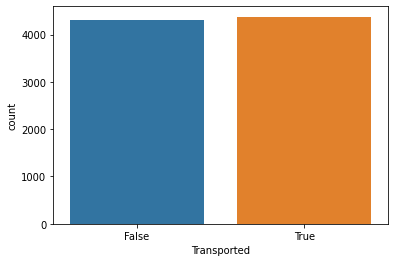

In [ ]:
sns.countplot(x="Transported",data=df)

In [ ]:
X.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Missing,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_Missing,Deck_T,Side_Missing,Side_P,Side_S
0,39.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
X_train.shape

(5796, 30)

# Setup ML Pipelines

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
pipelines={
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1234)),
    'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=1234))

}

In [ ]:
pipelines['rf']

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=1234))])

In [ ]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
grid={
    'rf': {
        'randomforestclassifier__n_estimators':[100,200,300]
        
    },
    'gb':{
        'gradientboostingclassifier__n_estimators':[100,200,300]
    }
}

In [ ]:
# Create a blank dictionary to hold the models

fit_models={}
# Loop through all the algos
for algo, pipeline in pipelines.items():
  print(f'Training the {algo} model')
  #Create a new Grid Search CV class
  model=GridSearchCV(pipeline, grid[algo], n_jobs=-1,cv=10)
  #Train the model
  model.fit(X_train,y_train)
  #Store results inside of the dictionary
  fit_models[algo]=model

Training the rf model
Training the gb model


# Evaluate performane on Test Partition
- Grab the testing data from test.csv and evaluate on that

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
#Evaluate performane of the model
for algo,model in fit_models.items():
  yhat=model.predict(X_test)
  accuracy=accuracy_score(y_test,yhat)
  precision=precision_score(y_test,yhat)
  recall=recall_score(y_test,yhat)
  print(f'Metrics for {algo}: accuracy--   {accuracy}, recall---   {recall}, precision--   {precision}')



Metrics for rf: accuracy--   0.7910276073619632, recall---   0.7646604938271605, precision--   0.8050365556458164
Metrics for gb: accuracy--   0.8075153374233128, recall---   0.8479938271604939, precision--   0.7827635327635327


# Save Best Model

In [ ]:
import pickle

In [ ]:
with open('gradientboosted.pkl','wb')as f:
  pickle.dump(fit_models['gb'],f)

# Predict on test data

In [ ]:
test_df=pd.read_csv('test.csv')

In [ ]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [ ]:
#Deep Copy
abt_test=test_df.copy()
#Preprocessing Pipeline
preprocessing(abt_test)
#One Hot Encoding categorical variables

abt_test=pd.get_dummies(abt_test.drop('PassengerId',axis=1))

In [ ]:
len(abt_test.columns)

32

In [ ]:
len(X.columns)

32

In [ ]:
yhat_test=fit_models['gb'].predict(abt_test)

In [ ]:
submission =pd.DataFrame([test_df['PassengerId'], yhat_test]).T
submission.columns=['PassengerID', 'Transported']

In [ ]:
submission

,PassengerID,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [ ]:
submission.to_csv('kaggle_submission.csv',index=False)